In [1]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math
import random
import os
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from scipy.interpolate import interp1d
import requests

In [2]:
def integrate_series(series, x0, x1):
    """
    Calculate the numerical integration of a Pandas Series within the range [x0, x1] using the trapezoidal rule.

    Parameters:
        - series: Pandas Series representing the function values with the corresponding x index.
        - x0: Lower limit of integration.
        - x1: Upper limit of integration.

    Returns:
        - The value of the numerical integration.
    """
    
    # Extract the x and y values from the Pandas Series
    x = series.index.values
    y = series.values

    # Find the indices corresponding to x0 and x1
    idx_start = np.abs(x - x0).argmin()
    idx_end = np.abs(x - x1).argmin()

    # Calculate the numerical integration using the trapezoidal rule
    integral = np.trapz(y[idx_start:idx_end+1], x[idx_start:idx_end+1])

    return integral

In [3]:
def dot_product(L1, L2):
    """
    Computing scalar product between two lists

    Parameters:
        - L1: First list.
        - L2: Second list.

    Returns:
        - Dot product.
    """
    if len(L1) != len(L2):
        raise ValueError("Lists must have same length. ")

    output = sum(x * y for x, y in zip(L1, L2))
    return output

### PCA Explanation

*The PCA technique extracts the principal components of a matrix, in this case it will extract the principal components of the historical variance of forward rates.*

Suppose we have $\mathbb{X}$ a matrix $m \times n$ where each row represents a forward rate and each column is a day. 

Now, we compute the covariance matrix $M_{\mathbb{X}}$ such that: 

$$M_{\mathbb{X}} = \frac{1}{n} \mathbb{X}\mathbb{X}^T$$

The goal of the PCA is to find a matrix $\mathbb{P}$ in $\mathbb{Y} = \mathbb{P}  \mathbb{X}$ such that $M_{\mathbb{Y}} = \frac{1}{n} \mathbb{Y}\mathbb{Y}^T \text{ is diagonal. }$

*That is, we look for a basis $\mathbb{Y}$ where the covariance of the associated observations is a diagonal matrix.*

$$M_{\mathbb{Y}} = \frac{1}{n} \mathbb{Y}\mathbb{Y}^T = \mathbb{P}\left( \mathbb{E} \mathbb{D}\mathbb{E}^T \right) \mathbb{P}^T$$

where: 
- $\mathbb{E}$ is the eigenvectors matrix
- $\mathbb{D}$ is the eigenvalues matrix

Clearly, if $\mathbb{P} = \mathbb{E}^T$ then: 

$$M_{\mathbb{Y}} = \mathbb{D}$$


### Using PCA in Heath, Jarrow and Morton Model

There are two ways to use HJM. 

- Choose the volatility structure $\nu_i(t, T)$ a priori to be sufficiently 'nice' to make a tractable model. 
- Choose a volatility structure matching data. This is where __PCA comes in__. 

<u>Assumptions:</u>

We will assume that volatility structure of the forward rate curve only depends on the time to maturity: 

$$\nu = \nu(T-t)$$

Model Dynamics: 

$$dF(t, T) = m(t,T)dt + \sum_{i = 1}^{N} \nu_i(T-t)dXi$$

Where:
- $dXi$ are uncorrelated
- $F(t, T)$ is the __instantaneous forward rate__, i.e. rate that one can contract at time $t$ on a riskless loan beginning at $T$ and returned an instant later. 

We have:

$$m(t, T) = \sum_{i = i}^{N} \nu_{i}(t, T)\int_{t}^{T}\nu_{i}(t, s)ds$$

Now suppose we have found the covariance matrix $\mathbb{M}$ for the changes in the 1M, 3M, 1Y, 5Y and 10Y for example (5 maturities in total for this case.)

This $5 \times 5$ matrix will have $5$ eigenvalues $\lambda_i$ and eigenvectors $v_i \in \mathbb{R}^5$. 

<u>Interpretaion:</u> The $k^{th}$ entry of the $v_i$ eigenvector corresponds to the $i^{th}$ principal component of the movement of the forward interest rate with $k^{th}$ maturity. 

The result of this analysis is: 

$$\sigma_k^2 = \sum_{j = 1}^{5} \lambda_j v_{jk}^2$$

Where $v_{jk}$ is the $k$-entry of the $j$-eigenvector. 

The variance has been decomposed in its principal components.

In rates analysis we choose normally $3$. 

<u>Final Result:</u>

$$\nu_i(\tau_j) = \sqrt{\lambda_i}(\vec{v_i})_j$$

First of all, we will retrieve __Bank of England instantaneous forward rate curve__, clean the data and manipulate it. This data can be interpreted as the market expectations for the spot rate at different points in the future. 

/var/folders/mc/sd8lk0kn4fz1q41w5qdn2fhc0000gn/T/ipykernel_9356/2766707607.py:12: FutureWarning: Treating integers as positional in Series.__setitem__ with a Float64Index is deprecated. In a future version, `series[an_int] = val` will insert a new key into the Series. Use `series.iloc[an_int] = val` to treat the key as positional.
  historical_rates[0] = historical_rates[1]


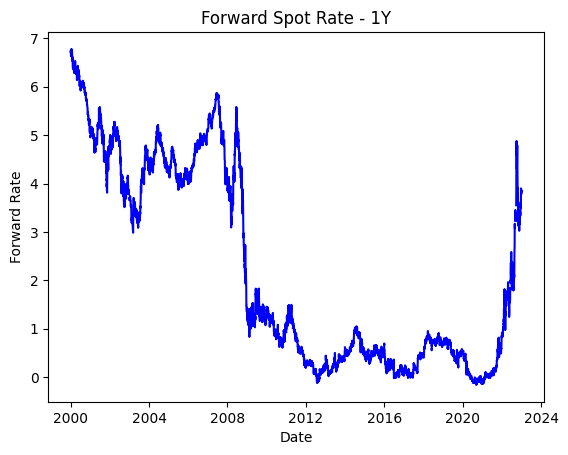

In [4]:
#We show the path where the data is.
path = "/Users/educontreras/PycharmProjects/Fixed-Income/BoE Yield Curve"
dir_list = os.listdir(path)
frames = []
for element in dir_list:
    if element != '.DS_Store':
        frames.append(pd.read_excel(f"{path}/{element}",index_col=0, header=3, sheet_name=2))
#We concatenate all available data
df = pd.concat(frames)
plt.plot(df.iloc[:, 1], color = "blue")
historical_rates = df.iloc[-1, :50].copy()
historical_rates[0] = historical_rates[1]
plt.xlabel("Date")
plt.ylabel("Forward Rate")
plt.title("Forward Spot Rate - 1Y")
#Now we compute the movements in rates from one day to the other. 
df = (df - df.shift(1)).iloc[:, :50]
df.dropna(how = "all", inplace = True)


### Applying PCA to Forward Rates

We could use the __sklearn.decomposition.PCA__ imported before, but instead, we will compute everything from scratch using the __numpy.linalg.eig__  package to compute eigenvectors and eigenvalues from the covariance matrix. It seems that only three or four components are fundamental to explain the variance in forward rate dynamics.

<BarContainer object of 6 artists>

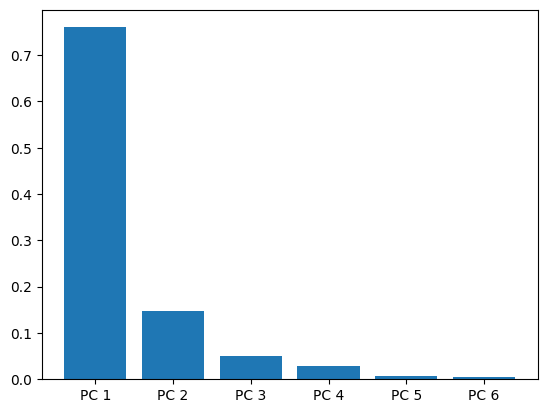

In [16]:

#Step 1: Computing the covariance matrix of variations in forward spot rate.
cov_matrix_array = df.cov().to_numpy()

#Now the eigenvalues and eigenvectors of covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_array)

#We have 50 maturities: so we will have 50 eigenvalues and eigenvectors. Here the dataframe with the eigenvalues.
df_eigval = pd.DataFrame({"Eigenvalues":eigenvalues}, index=range(1,51))
df_eigval["Explained proportion"] = df_eigval["Eigenvalues"] / np.sum(df_eigval["Eigenvalues"])
df_eigval.style.format({"Explained proportion": "{:.2%}"})

plt.bar([f"PC {i}" for i in range(1,7)],df_eigval.loc[:6, "Explained proportion"])


Now we will create the volatility structure where we will have the volatility principal components (from 1 to 4) for each available maturity. 

In [17]:
df_vol_structure = pd.DataFrame(columns = df.columns, index = range(1, 5))
for component in range(4):
    df_vol_structure.iloc[component, :] = math.sqrt(eigenvalues[component])*eigenvectors[component]
df_vol_structure = df_vol_structure.T

In order to integrate numerically having a bunch of values, we will interpolate these principal components to have them for 1000 maturities between 0.5 and 25. 

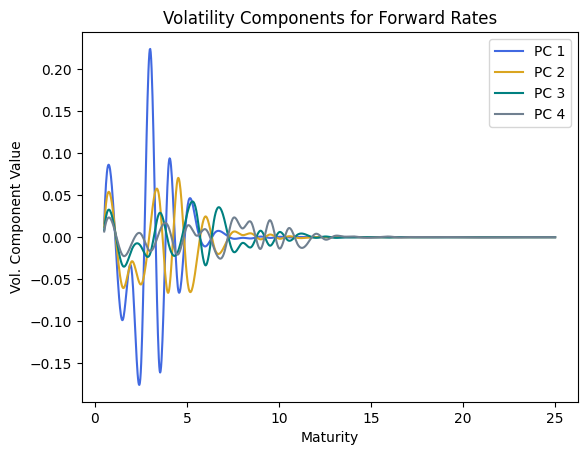

In [18]:
df_vol_interpolated = df_vol_structure.copy()
# Let us create an example dataframe
maturities = list(df_vol_structure.index)
data = np.random.rand(len(maturities), 4)
df = pd.DataFrame(data, index=maturities, columns=['Column1', 'Column2', 'Column3', 'Column4'])

# Definir el nuevo rango de maturities
new_maturities = np.linspace(0.5, 25, 1000)

# Crear un nuevo DataFrame para almacenar los resultados interpolados
df_vol_interpolated = pd.DataFrame(index=new_maturities)
historical_rates_interpolated = pd.DataFrame(index=new_maturities, columns = ["Forward Rate"])
# Realizar interpolación cúbica para cada columna del DataFrame original
for column in df_vol_structure.columns:
    # Obtener los valores conocidos para la columna actual
    y_known = df_vol_structure[column].values

    # Crear la función de interpolación cúbica
    interp_func = interp1d(maturities, y_known, kind='cubic')

    # Realizar la interpolación cúbica para los nuevos maturities
    y_interpolated = interp_func(new_maturities)

    # Agregar los valores interpolados al DataFrame de resultados
    df_vol_interpolated[column] = y_interpolated

    # Obtener los valores conocidos para la columna actual
y_known = historical_rates.values

    # Crear la función de interpolación cúbica
interp_func = interp1d(maturities, y_known, kind='cubic')

    # Realizar la interpolación cúbica para los nuevos maturities
y_interpolated = interp_func(new_maturities)

    # Agregar los valores interpolados al DataFrame de resultados
historical_rates_interpolated["Forward Rate"] = y_interpolated    

colors = ['royalblue', 'goldenrod', 'teal', 'slategrey']

# Plotting all columns using a for loop
fig, ax = plt.subplots()

for i, column in enumerate(df_vol_interpolated.columns):
    ax.plot(df_vol_interpolated[column], color=colors[i], label=f"PC {column}")

ax.legend()  # Show legend with column names
plt.xlabel('Maturity')
plt.ylabel('Vol. Component Value')
plt.title('Volatility Components for Forward Rates')
spot_curve = historical_rates_interpolated.copy()
del historical_rates_interpolated


<AxesSubplot:>

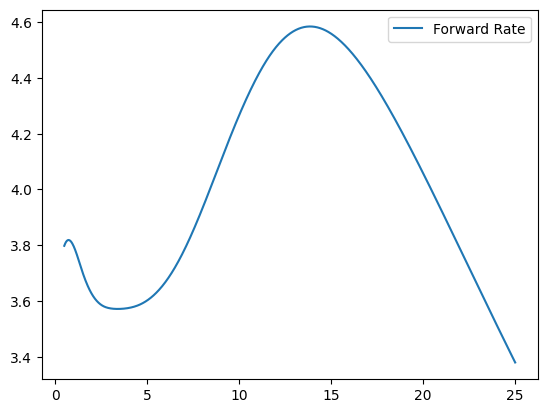

In [19]:
spot_curve.plot()

So here are the __three principal components per time to maturity__: 

Now we have the principal components of volatility for each retrieved maturity. 

so we have the followinf difference equation: 

$$\Delta f(t, T) = \alpha (T - t)\Delta t + \sum_{i = 1}^{4} \sigma_i (T - t) \Delta W_i(t)$$

Assuming the variations of forward rates are gaussian for each maturity, the natural estimator for $\alpha(T - t)$ is the empiric average. Thus, 

$$\hat{\alpha}(T - t) = \frac{1}{m}\sum_{j = 1}^{m}X_j(T-t)$$

Where $m$ corresponds to the number of observations. 

However, we have preferred to calculate an approximation to the numerical integral and use the following formula:

$$\alpha(t, T-t) = \sum_{i = 1}^{N}\sigma_i(t,T)\int_{t}^{T}\sigma_i(t,s)ds$$

In [20]:
# The estimator of alpha will be the mean for every mean variation
alpha = pd.DataFrame(index = list(df_vol_interpolated.index), columns = ["Alpha Value"])
for maturity in alpha.index:
    integrals = [integrate_series(df_vol_interpolated[col], 0, maturity) for col in df_vol_interpolated.columns]
    alpha.loc[maturity, "Alpha Value"] = dot_product(df_vol_interpolated.loc[maturity, :].values, integrals)
alpha

,Alpha Value
0.500000,0.0
0.524525,0.000032
0.549049,0.00011
0.573574,0.000243
0.598098,0.00043
...,...
24.901902,-0.0
24.926426,-0.0
24.950951,-0.0
24.975475,0.0


In [21]:
def simulation(spot_curve, drift, vols, timeline):
    f = spot_curve.copy()
    tenors = drift.index
    len_tenors = len(tenors)
    len_vols = len(list(vols.columns))
    for it in tqdm(range(1, len(timeline))):
        t = timeline[it]
        dt = t - timeline[it - 1]
        sqrt_dt = math.sqrt(dt)
        fprev = f.copy()
        random_numbers = [random.gauss(0, 1) for i in range(len_vols)]
        #Now we will simulate the new whole curve at point in time t
        for iT in range(len_tenors):
            val = fprev.iloc[iT, 0] + drift.iloc[iT]*dt
            sum = 0
            for vol_component in range(len_vols):
                sum += vols.iloc[iT, vol_component]*random_numbers[vol_component]
            val += sum*sqrt_dt
            iT1 = iT+1 if iT<len_tenors-1 else iT-1   # if we can't take right difference, take left difference
            dfdT = (fprev.iloc[iT1, 0] - fprev.iloc[iT, 0]) / (iT1 - iT)
            val += dfdT * dt
            f.iloc[iT] = val
    return f

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:20<00:00,  4.87it/s]


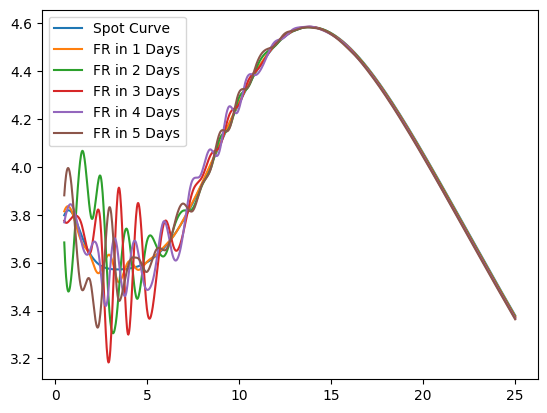

In [22]:
mc_drift = alpha.copy()
mc_vol = df_vol_interpolated
x = mc_drift.index
plt.figure()
plt.plot(x, spot_curve, label=f'Spot Curve')
for i in range(1, 6):
    timeline = np.linspace(0,i,100)
    y = simulation(spot_curve, mc_drift, mc_vol, timeline)
    plt.plot(x, y, label=f'FR in {i} Days')

#fig.update_layout(title='Forward Curve Simulations',
#                  xaxis_title='Tenor (in Yrs.)',
#                  yaxis_title='Rate')

plt.legend()

# Mostrar el gráfico con todas las series temporales
plt.show()